In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_about'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6956615126091429 	 Validation loss: 0.6922371579428851 	 
  1%|          | 574/57400 [00:04<07:28, 126.76it/s]
Epoch 2 	 Training loss: 0.6896094065094659 	 Validation loss: 0.6884347422648285 	 
  2%|▏         | 1148/57400 [00:09<07:18, 128.40it/s]
Epoch 3 	 Training loss: 0.6861111153085888 	 Validation loss: 0.6861907223523673 	 
  3%|▎         | 1722/57400 [00:14<07:12, 128.85it/s]
Epoch 4 	 Training loss: 0.6840943747073516 	 Validation loss: 0.6851727861469075 	 
  4%|▍         | 2296/57400 [00:19<07:05, 129.55it/s]
Epoch 5 	 Training loss: 0.682932291504398 	 Validation loss: 0.6845204961501946 	 
  5%|▌         | 2870/57400 [00:24<07:08, 127.21it/s]
Epoch 6 	 Training loss: 0.6822612883737278 	 Validation loss: 0.6842890381813049 	 
  6%|▌         | 3444/57400 [00:29<06:52, 130.66it/s]
Epoch 7 	 Training loss: 0.6818332556855803 	 Validation loss: 0.6840344455282567 	 
  7%|▋         | 4018/57400 [00:34<06:51, 129.59it/s]
Epoch 8 	 Training loss: 0.68

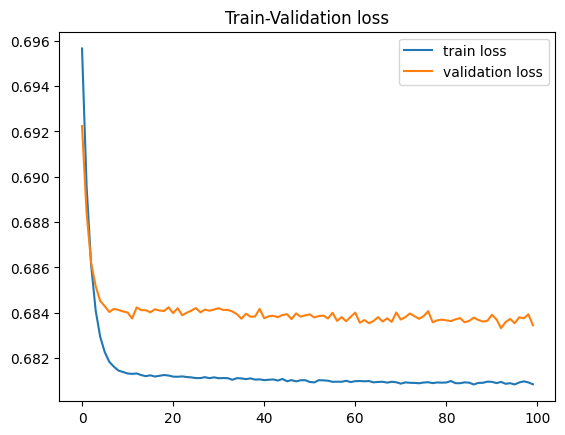

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936459539243984 	 Validation loss: 0.6919492846828396 	 
  1%|          | 574/57400 [00:05<08:19, 113.79it/s]
Epoch 2 	 Training loss: 0.6933621936558846 	 Validation loss: 0.6923824013289759 	 
  2%|▏         | 1148/57400 [00:10<08:09, 114.88it/s]
Epoch 3 	 Training loss: 0.6932920940246317 	 Validation loss: 0.6923607032177812 	 
  3%|▎         | 1722/57400 [00:16<08:00, 115.82it/s]
Epoch 4 	 Training loss: 0.6931388084273721 	 Validation loss: 0.6927823666798867 	 
  4%|▍         | 2296/57400 [00:21<08:05, 113.53it/s]
Epoch 5 	 Training loss: 0.6932144549250188 	 Validation loss: 0.6928523273791297 	 
  5%|▌         | 2870/57400 [00:27<07:50, 115.82it/s]
Epoch 6 	 Training loss: 0.6932139818261309 	 Validation loss: 0.6930691953432762 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:32<07:50, 114.78it/s]
Epoch 7 	 Training loss: 0.6931573783894449 	 Validation loss: 0.693205541473324 	 

2 epoch without improvement
  7%|▋         | 4018/574

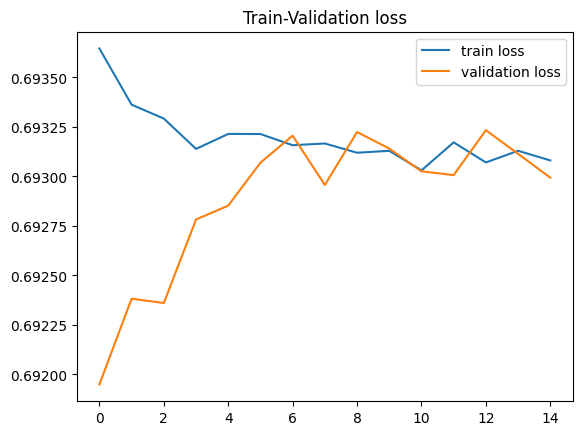

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934054959111098 	 Validation loss: 0.6923502229027829 	 
  1%|          | 574/57400 [00:05<08:03, 117.63it/s]
Epoch 2 	 Training loss: 0.69327648124213 	 Validation loss: 0.692689406669746 	 
  2%|▏         | 1148/57400 [00:10<08:39, 108.36it/s]
Epoch 3 	 Training loss: 0.6932294143409263 	 Validation loss: 0.6924881813889843 	 
  3%|▎         | 1722/57400 [00:16<07:56, 116.88it/s]
Epoch 4 	 Training loss: 0.6933365507823664 	 Validation loss: 0.6924481159549648 	 
  4%|▍         | 2296/57400 [00:21<07:51, 116.97it/s]
Epoch 5 	 Training loss: 0.693270565221534 	 Validation loss: 0.6925404425394737 	 
  5%|▌         | 2870/57400 [00:27<08:10, 111.10it/s]
Epoch 6 	 Training loss: 0.6931837909313029 	 Validation loss: 0.6926373768660982 	 
  6%|▌         | 3444/57400 [00:32<07:48, 115.12it/s]
Epoch 7 	 Training loss: 0.6932498342276451 	 Validation loss: 0.6926306799306707 	 
  7%|▋         | 4018/57400 [00:38<08:01, 110.86it/s]
Epoch 8 	 Training loss: 0.69323

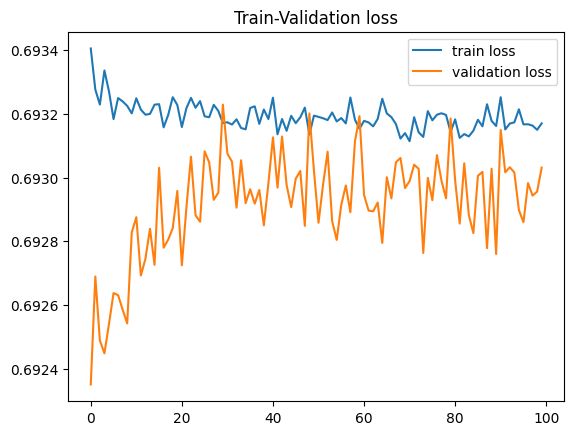

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5063775510204082 

Using scikit learn accuracy por género en el conjunto about
MALE 0.033854166666666664
FEMALE 0.96 

GLOBAL: 0.4772727272727273 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0413625304136253
FEMALE 0.94750656167979 

GLOBAL: 0.48891786179921776 

Using scikit learn accuracy por género en el conjunto as
MALE 0.045454545454545456
FEMALE 0.9622641509433962 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_about_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6789416291780173 	 Validation loss: 0.6754049123343775 	 
  1%|          | 574/57400 [00:05<08:26, 112.16it/s]
Epoch 2 	 Training loss: 0.6618870333719752 	 Validation loss: 0.6568914308386334 	 
  2%|▏         | 1148/57400 [00:11<08:25, 111.34it/s]
Epoch 3 	 Training loss: 0.6512624418901649 	 Validation loss: 0.6515433495327577 	 
  3%|▎         | 1722/57400 [00:16<08:38, 107.31it/s]
Epoch 4 	 Training loss: 0.6435210778530467 	 Validation loss: 0.6409616955256058 	 
  4%|▍         | 2296/57400 [00:22<08:44, 104.99it/s]
Epoch 5 	 Training loss: 0.6358875182655215 	 Validation loss: 0.6338731959714727 	 
  5%|▌         | 2870/57400 [00:27<08:00, 113.55it/s]
Epoch 6 	 Training loss: 0.6282533348022022 	 Validation loss: 0.627042457208795 	 
  6%|▌         | 3444/57400 [00:33<07:50, 114.78it/s]
Epoch 7 	 Training loss: 0.6194272820127135 	 Validation loss: 0.6208412748272136 	 
  7%|▋         | 4018/57400 [00:38<07:41, 115.69it/s]
Epoch 8 	 Training loss: 0.61

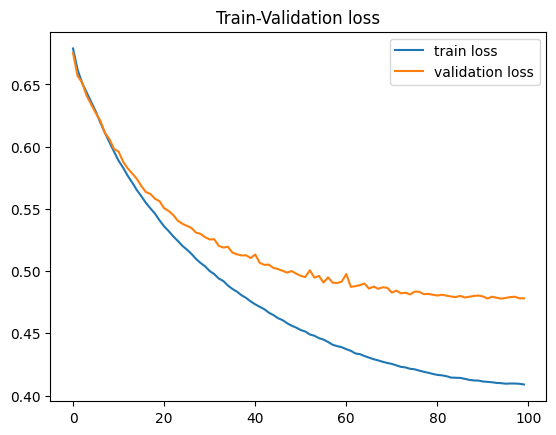

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7334183673469388 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8098958333333334
FEMALE 0.66 

GLOBAL: 0.5782828282828283 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6715328467153284
FEMALE 0.4776902887139108 

GLOBAL: 0.5971316818774446 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6691919191919192
FEMALE 0.5202156334231806 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932736104581414 	 Validation loss: 0.6931035417621418 	 
  1%|          | 574/57400 [00:06<09:19, 101.64it/s]
Epoch 2 	 Training loss: 0.6931288408485439 	 Validation loss: 0.6921958852622468 	 
  2%|▏         | 1148/57400 [00:12<09:09, 102.40it/s]
Epoch 3 	 Training loss: 0.6931374388704732 	 Validation loss: 0.6927251411696612 	 
  3%|▎         | 1722/57400 [00:18<09:10, 101.06it/s]
Epoch 4 	 Training loss: 0.6931112456404789 	 Validation loss: 0.6935000621666343 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:31, 96.46it/s]
Epoch 5 	 Training loss: 0.6930735127851108 	 Validation loss: 0.694374792656656 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:30<09:07, 99.51it/s]
Epoch 6 	 Training loss: 0.6931222510047075 	 Validation loss: 0.6928415551023969 	 
  6%|▌         | 3444/57400 [00:37<09:17, 96.81it/s]
Epoch 7 	 Training loss: 0.6930669448516925 	 Validation loss: 0.6928276712611571 	 
  7%|▋         | 4018/57400 

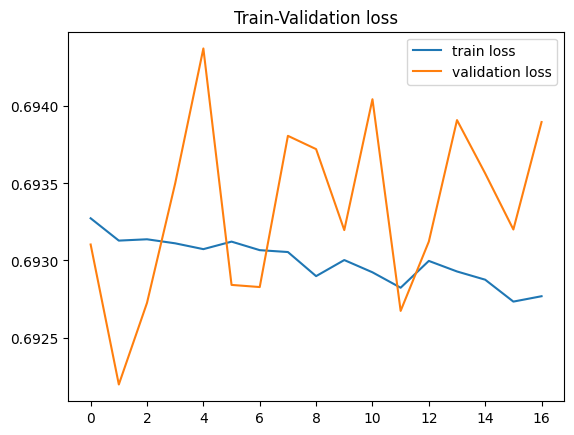

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5153061224489796 

Using scikit learn accuracy por género en el conjunto about
MALE 0.028645833333333332
FEMALE 0.9825 

GLOBAL: 0.47474747474747475 

Using scikit learn accuracy por género en el conjunto to
MALE 0.021897810218978103
FEMALE 0.963254593175853 

GLOBAL: 0.47979139504563234 

Using scikit learn accuracy por género en el conjunto as
MALE 0.017676767676767676
FEMALE 0.9730458221024259 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932767712696088 	 Validation loss: 0.6917479755514759 	 
  1%|          | 574/57400 [00:06<09:29, 99.73it/s]
Epoch 2 	 Training loss: 0.6932118705340794 	 Validation loss: 0.6934800855184006 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:45, 96.01it/s]
Epoch 3 	 Training loss: 0.6930943946597468 	 Validation loss: 0.6917652467549857 	 
  3%|▎         | 1722/57400 [00:18<09:40, 95.88it/s]
Epoch 4 	 Training loss: 0.6930008621996704 	 Validation loss: 0.6935142389798569 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:35, 95.74it/s]
Epoch 5 	 Training loss: 0.6930011153636494 	 Validation loss: 0.6927686202324043 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:33, 95.06it/s]
Epoch 6 	 Training loss: 0.6928884573929817 	 Validation loss: 0.6929393390477714 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:07, 98.52it/s]
Epoch 7 	 Training loss: 0.6928676604601565 	 Validation 

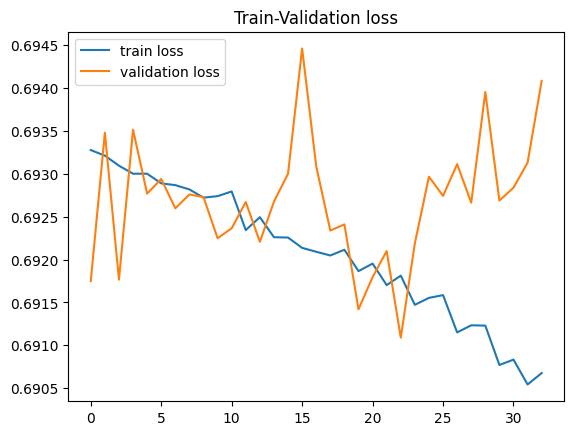

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4885204081632653 

Using scikit learn accuracy por género en el conjunto about
MALE 0.5859375
FEMALE 0.395 

GLOBAL: 0.5404040404040404 

Using scikit learn accuracy por género en el conjunto to
MALE 0.610705596107056
FEMALE 0.4645669291338583 

GLOBAL: 0.5176010430247718 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6060606060606061
FEMALE 0.42318059299191374 

